In [73]:
%load_ext autoreload
%autoreload 

from preprocessing.preprocess_ucr import UCRDatasetImporter
from preprocessing.preprocess_ucr import UCRDataset
from preprocessing.preprocess_ucr import AugUCRDataset
from preprocessing.data_pipeline import build_data_pipeline
from utils import load_yaml_param_settings

from utils import time_to_timefreq, timefreq_to_time
from preprocessing.augmentations import TimeFreqAugmenter, Augmenter
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import torch.nn.functional as F
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
config = load_yaml_param_settings("configs/config.yaml")

config['dataset']['dataset_name'] = 'UWaveGestureLibraryAll'
config["VQVAE"]["n_fft"] = 8

# data pipeline
dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage1"]
train_data_loader_aug = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=True
)
train_data_loader = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=False
)

test_data_loader = build_data_pipeline(batch_size, dataset_importer, config, "test")

augmenter = TimeFreqAugmenter(**config["augmentations"]["aug_params"])

self.X_train.shape: (896, 945)
self.X_test.shape: (3582, 945)
# unique labels (train): [0 1 2 3 4 5 6 7]
# unique labels (test): [0 1 2 3 4 5 6 7]


In [75]:
for batch in train_data_loader_aug:
    x_batch, y = batch
    break

In [76]:
x, xs_pairs = x_batch

In [77]:
x = x.squeeze(1).numpy()
print(x.shape)

(128, 945)


In [78]:
def add_random_crop(subseq_len: int, *subx_views):
    cropped_views = []
    rand_ts = []
    for subx in subx_views:
        seq_len = subx.shape[-1]
        rand_t = np.random.randint(0, seq_len - subseq_len + 1, size=1)[0]
        cropped_subx = subx[:, rand_t : rand_t + subseq_len]  # (subseq_len)
        cropped_views.append(cropped_subx)
        rand_ts.append(rand_t)

    if len(cropped_views) == 1:
        cropped_views = cropped_views[0]
    return cropped_views

In [84]:
test = add_random_crop(20, x)

IndexError: too many indices for tensor of dimension 1

(128, 10)


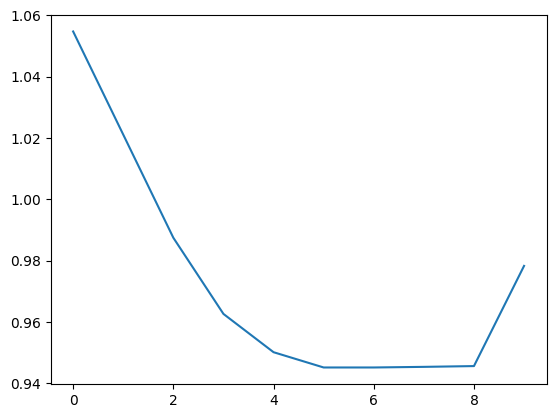

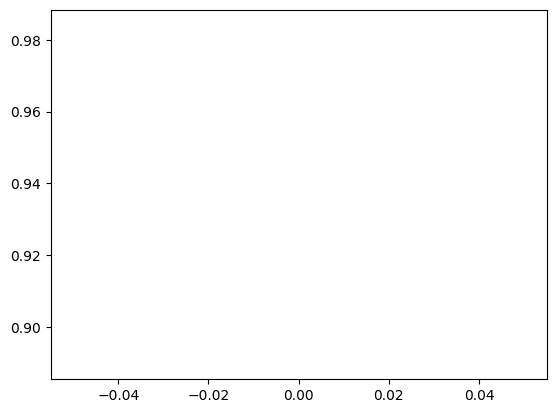

In [81]:
idx = np.random.randint(0, x.shape[0])

plt.plot(x[0, 0])
plt.plot(subx1[0, 0])

In [82]:
def get_x_u():
    X = torch.tensor(train_data_loader.dataset.X)
    x = X[np.random.randint(0, X.shape[0])]
    return x, augmenter.stft(x)



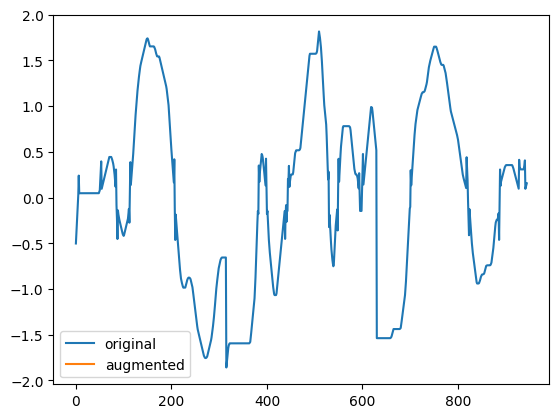

In [83]:

config = load_yaml_param_settings("configs/config.yaml")


aug = Augmenter(**config["augmentations"])


x, _ = get_x_u()
xaug = aug.augment(x)
plt.plot(x, label="original")
plt.plot(xaug, label="augmented")  # Include the augmented signal in the plot
plt.legend()
plt.show()#plot the original and augmented signals